# first prototype of text2image app

In [4]:
from sentence_transformers import SentenceTransformer
from PIL import Image
import glob
import numpy as np
import pandas as pd
from tqdm import tqdm

In [5]:
## load image paths

image_paths = glob.glob('./data/*.jpg')

image_paths[:6]

['./data/65631.jpg',
 './data/90900.jpg',
 './data/94890.jpg',
 './data/90610.jpg',
 './data/164311.jpg',
 './data/55901.jpg']

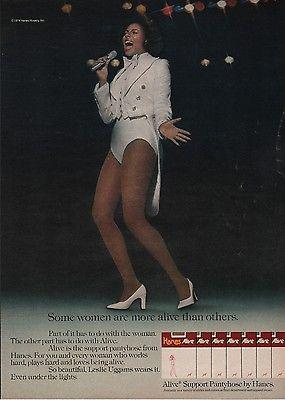

In [6]:
image = Image.open(image_paths[0])
image

In [7]:
## laod encoder model

model = SentenceTransformer("clip-ViT-B-32", device='cuda')

In [8]:
## test it

test_embedding = model.encode(image)

print(len(test_embedding))
print(test_embedding[:20])

test_embedding = np.array(test_embedding, dtype=np.float32)

print(np.sqrt(np.sum(test_embedding**2)))

## note: vectors are not normalized

512
[-0.24101439 -0.02133767 -0.13979056 -0.29986262  0.2614178  -0.21153747
 -0.27264494  0.10491259 -0.30845255 -0.21523714 -0.06234296  0.13983604
  0.69605315  0.2278687   0.54724705 -0.8063965   0.7679024   0.02878965
  0.71990967  0.14955826]
10.951274


In [26]:

def embed_image(path : str):
    
    image = Image.open(path)
    
    return model.encode(image)

def batch_encode(image_paths : str):
    
    images = [Image.open(path) for path in tqdm(image_paths)]
    
    return model.encode(images, batch_size=1024, show_progress_bar=True)
    
## reduce dataset size for testing purposes
image_paths = image_paths[:100]

embeddings = batch_encode(image_paths)


100%|██████████| 100/100 [00:00<00:00, 13543.56it/s]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
print(type(embeddings))
print(embeddings[0][:20])

<class 'numpy.ndarray'>
[-0.24101415 -0.02133736 -0.13979104 -0.29986256  0.2614174  -0.21153764
 -0.27264464  0.1049121  -0.30845162 -0.21523646 -0.06234238  0.13983622
  0.696053    0.22786918  0.54724705 -0.8063961   0.76790214  0.02878881
  0.71990985  0.14955883]


In [11]:
from qdrant_client import QdrantClient
from qdrant_client.http import models as rest

In [15]:
!docker run -d -p "6333:6333" -p "6334:6334" --name "image_search_2" qdrant/qdrant:latest

59253a7ebd8d444057cc7ea56ae3482286965b26cfa780e066301a67bb18aed9


In [16]:
client = QdrantClient('localhost')

In [17]:
collections = client.get_collections()
collections

CollectionsResponse(collections=[])

In [29]:
client.recreate_collection(
    collection_name='ads-images',
    vectors_config=rest.VectorParams(
        size=512,
        distance=rest.Distance.COSINE,
    )
)

True

In [30]:
import uuid
assert len(embeddings) == len(image_paths)
client.upload_collection(
    collection_name="ads-images",
    vectors=list(embeddings),
    payload=[{'image_path': path} for path in image_paths],
    ids=[uuid.uuid4().hex for _ in image_paths],
)

In [31]:
search_result = client.search(
    collection_name="ads-images",
    query_vector=model.encode('woman singing')
)
search_result

[ScoredPoint(id='d60f214b-5715-4f82-9f23-3978faae8ff5', version=2, score=0.25512263, payload={'image_path': './data/65631.jpg'}, vector=None, shard_key=None),
 ScoredPoint(id='77a7286d-f5fb-4720-8dd8-fd13ed89281a', version=2, score=0.22529325, payload={'image_path': './data/91870.jpg'}, vector=None, shard_key=None),
 ScoredPoint(id='cf9be999-0ffb-4384-b908-7d2ac11e3513', version=2, score=0.22089094, payload={'image_path': './data/84130.jpg'}, vector=None, shard_key=None),
 ScoredPoint(id='58a344d6-1aba-475d-b424-7e7f7c27c449', version=2, score=0.2131108, payload={'image_path': './data/23071.jpg'}, vector=None, shard_key=None),
 ScoredPoint(id='667b7454-f4b3-45fd-85a8-6099e9700ee0', version=2, score=0.21120384, payload={'image_path': './data/29031.jpg'}, vector=None, shard_key=None),
 ScoredPoint(id='0b7d0046-0900-4de2-8957-5b323307b641', version=5, score=0.20280443, payload={'image_path': './data/32440.jpg'}, vector=None, shard_key=None),
 ScoredPoint(id='bfd01278-8237-4ad0-97e2-3f9142

In [32]:
from IPython.display import display, HTML

def show_results(search_result):
    output_images = [data.payload['image_path'] for data in search_result]
    images_html = "".join(
        f"<td><img src='{image_path}' width=200></td>"
        for image_path in output_images
    )
    display(HTML(f"<table><tr>{images_html}</tr></table>"))

In [22]:
show_results(search_result)

,,,,,,,,,


In [23]:

def search(query: str):
    search_result = client.search(
    collection_name="ads-images",
    query_vector=model.encode(query)
    )
    print([data.score for data in search_result])
    output_images = [data.payload['image_path'] for data in search_result]
    images_html = "".join(
        f"<td><img src='{path}' width=150></td>"
        for path in output_images
    )
    display(HTML(f"<table><tr>{images_html}</tr></table>"))

In [33]:
search("woman")

[0.24555716, 0.23850313, 0.23543644, 0.22709674, 0.22500879, 0.22419706, 0.22392297, 0.21657586, 0.21655598, 0.21488383]


,,,,,,,,,


In [25]:
search('car')

[0.2541098, 0.24260129, 0.23683116, 0.23162307, 0.22691406, 0.22552772, 0.22181028, 0.21513541, 0.20985414, 0.20860733]


,,,,,,,,,


In [34]:
search('fast car')

[0.2649483, 0.23712006, 0.23455416, 0.23427418, 0.22395095, 0.21780172, 0.21583897, 0.21101359, 0.20454949, 0.20233543]


,,,,,,,,,
